In [2]:
import os
os.chdir('/home/invisibleman/Robotics/adaptive-coverage-with-voronoi')

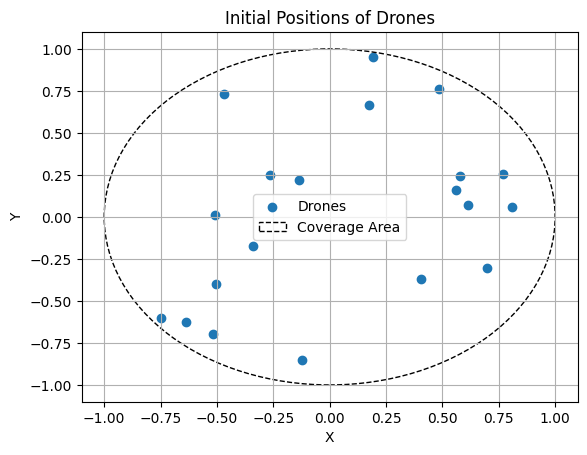

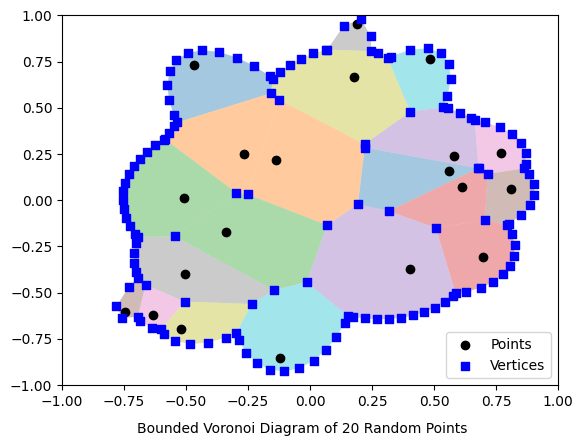

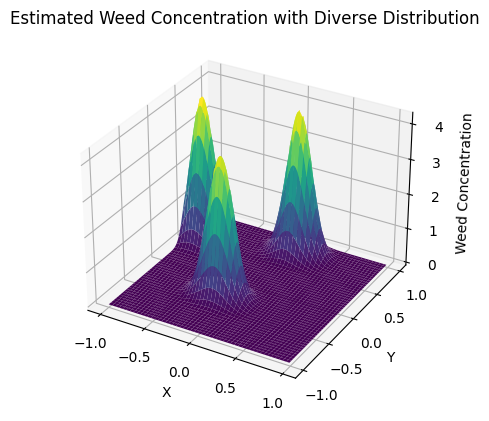

In [4]:
from initialization import initial_setup
from sensor import sensor_func
from dintegrate import integrate_sensor_values
from utils import voronoi
import numpy as np

# Number of drones
n = 20

# Radius of the circular area to be covered
r = 1

vor, finite_vertices, finite_regions, voronoi_centers, grid_points, weed_density = initial_setup(n, r)

In [3]:
def test_integrate_sensor_values_with_neighbours(vor, finite_vertices, finite_regions, voronoi_centers, 
                                                    time_step=0.05, time_limit=5, distance_threshold=0.5):
    """
    Test the function integrate_sensor_values by performing integration for each Voronoi center and its neighbours.
    
    Parameters:
    vor (scipy.spatial.qhull.Voronoi): Voronoi diagram.
    finite_vertices (list): List of vertices of finite Voronoi regions.
    finite_regions (list): List of finite Voronoi regions.
    voronoi_centers (np.array): Coordinates of Voronoi centers.
    time_step (float): Time step for integration. Default is 0.05.
    time_limit (float): Time limit for integration. Default is 5.
    distance_threshold (float): Threshold distance for determining neighbours. Default is 0.5.

    Returns:
    None
    """

    # Compute Voronoi neighbours for each Voronoi center
    neighbours = voronoi.compute_voronoi_neighbours(voronoi_centers, distance_threshold)

    # For each Voronoi center
    for i, center in enumerate(voronoi_centers):
        print(f"\nProcessing Voronoi center {i}...")

        # Get the corresponding partition
        partition = finite_vertices[i]

        # Integrate sensor values for the center
        mv, lv, cv = integrate_sensor_values(sensor_func, partition, center, grid_points, weed_density, time_step, time_limit)
        print(f"For the center itself, mv: {mv}, lv: {lv}, cv: {cv}")

        # For each neighbour of the current center
        for neighbour_index in neighbours[i]:
            # Get the corresponding partition
            partition = finite_vertices[neighbour_index]

            # Integrate sensor values for the neighbour
            mv, lv, cv = integrate_sensor_values(sensor_func, partition, voronoi_centers[neighbour_index], grid_points, weed_density, time_step, time_limit)
            print(f"For neighbour {neighbour_index}, mv: {mv}, lv: {lv}, cv: {cv}")

In [ ]:
test_integrate_sensor_values_with_neighbours(vor, finite_vertices, finite_regions, voronoi_centers, 
                                                    time_step=0.05, time_limit=5, distance_threshold=0.5)

In [6]:
def optimize_voronoi_centers_consensus(voronoi_centers, finite_vertices, finite_regions, 
                                        grid_points, weed_density, sensor_func, neighbours, 
                                        time_step=0.05, time_limit=5, alpha=0.1, beta=0.1, 
                                        epsilon=1e-6, max_iter=100):
    """
    Optimize Voronoi centers using gradient descent and consensus algorithm.
    
    Parameters:
    voronoi_centers (np.array): Coordinates of Voronoi centers.
    finite_vertices (list): List of vertices of finite Voronoi regions.
    finite_regions (list): List of finite Voronoi regions.
    sensor_func (function): Sensor function.
    neighbours (list): List of lists where each sublist contains the indices of neighbouring Voronoi centers for a given center.
    time_step (float): Time step for integration. Default is 0.05.
    time_limit (float): Time limit for integration. Default is 5.
    alpha (float): Learning rate for gradient descent. Default is 0.1.
    beta (float): Weight for the consensus term. Default is 0.1.
    epsilon (float): Threshold for determining convergence. Default is 1e-6.
    max_iter (int): Maximum number of iterations. Default is 100.

    Returns:
    np.array: Updated coordinates of Voronoi centers.
    """
    for iter in range(max_iter):
        # Initialize change to zero
        change = 0

        # For each Voronoi center
        for i, center in enumerate(voronoi_centers):
            # Get the corresponding partition
            partition = finite_vertices[i]

            # Calculate the moment integrals
            mv, lv, cv = integrate_sensor_values(sensor_func, partition, center, 
                                                grid_points, weed_density, 
                                                time_step, time_limit)

            # Calculate the consensus term
            consensus_term = sum(voronoi_centers[j] - center for j in neighbours[i])

            # Calculate the gradient (negative of the derivative of the cost function, with consensus term)
            gradient = -mv * (cv - center) + beta * consensus_term

            # Update the Voronoi center
            new_center = center - alpha * gradient

            # Calculate the change in position
            change = max(change, np.linalg.norm(new_center - center))

            # Update the Voronoi center
            voronoi_centers[i] = new_center

        # Check for convergence
        if change < epsilon:
            print("Converged after", iter, "iterations.")
            break

    if iter == max_iter - 1:
        print("Reached maximum number of iterations without convergence.")

    return voronoi_centers


In [ ]:
optimize_voronoi_centers_consensus(voronoi_centers, finite_vertices, finite_regions, 
                                        grid_points, weed_density, sensor_func, neighbours, 
                                        time_step=0.05, time_limit=5, alpha=0.1, beta=0.1, 
                                        epsilon=1e-6, max_iter=100)